# Density profile of Hyades

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib import colors, ticker

import pandas as pd
import numpy as np
import scipy as sp
import astropy.units as u
import arviz as az
import seaborn as sns
import gapipes as gp

In [3]:
out_full = pd.read_csv("../data/hyades_full.csv")
# %store -r out_full
df = out_full.loc[out_full['in_dr2'] == True]
print(f'{len(df)} rows in DR2 sample')

icrs = df.g.icrs
galactic = df.g.galactic
b_c = np.array([-44.16, 0.66, -17.76])    # Galactic, in pc from Reino 2018

relpos = galactic.cartesian.xyz.value - b_c[:,None]
r = np.linalg.norm(relpos, axis=0)

515 rows in DR2 sample


In [4]:
reino = pd.read_csv("../data/reino_tgas_full.csv",index_col=0)
print(f"{len(reino)} rows in Reino TGAS sample")

icrs_reino = reino.g.icrs
galactic_reino = reino.g.galactic
b_c = np.array([-44.16, 0.66, -17.76])    # Galactic, in pc from Reino 2018

relpos_reino = galactic_reino.cartesian.xyz.value - b_c[:,None]
r_reino = np.linalg.norm(relpos_reino, axis=0)

173 rows in Reino TGAS sample


In [7]:
# matplotlib styles
plt.rc("text", usetex=True)
plt.rc('font', size=14, family='serif')
plt.rc('axes', labelsize=16)
plt.style.use('smoh')

I calculate spherically-averaged density profile using histogram of radius $r = |\vec{b_i} - \vec{b_c}|$ where the center, $\vec{b_c}$, is assumed to be that given in Reino et al. 2018 and $\vec{b_i}$ is the position vector of star $i$.
The count, $N(r)$ from binning in $r$ is related to the number density as:

$$ n(r) = \frac{N(r)}{4 \pi r^2 dr} $$

where $dr$ is the bin size and I take the center of each (equally-sized) bin as $r$.

## Reino 2018 - sanity check fails.

Figure 4 is the numder density profile of **TGAS sources around Hyades**. The blue and green compares before removing 173 members they have selected and after. Thus, the difference between the two is attributed to the cluster.

![](https://oup.silverchair-cdn.com/oup/backfile/Content_public/Journal/mnras/477/3/10.1093_mnras_sty793/2/m_sty793fig4.jpeg?Expires=1570804540&Signature=4SHOVPlDZyNwjjLcNgP1iMKoTZgLZ-7gm-MOZ2OoPuWxj7tOX~9LFOkTxvcPOd-Oqkc6FuqXuEBJtWlM6pF~4jNvpLpuectx2A7Cof-UISkSLEsINoILNiV~zkYn6s3SI4qstJA0MbJ~tLo8JDMiap8nr3-2DCltAsbWt1kBZYTntog9s1JlidwgvE9eNCjscmHlikNW0KgqsvjTqhJNSkK-Jm23RzNJGcI-4ox1rnwGHf8SZamnZM41HNDzMZM64TOJTdvgHdQ5BJqLfIuT66Jw42lu5twNd4y-uZ2IXCsYQDbJbuvQLDWWvIxkd-kRZwBRbLp22Vovu4-1hZdlMQ__&Key-Pair-Id=APKAIE5G5CRDK6RD3PGA)

As a sanity check, I calculate the number desnity using the **173 member stars** in Reino. The expectation is that the profile will be the difference (blue - green).
However, I find that the density is much smaller than the difference (blue-green).

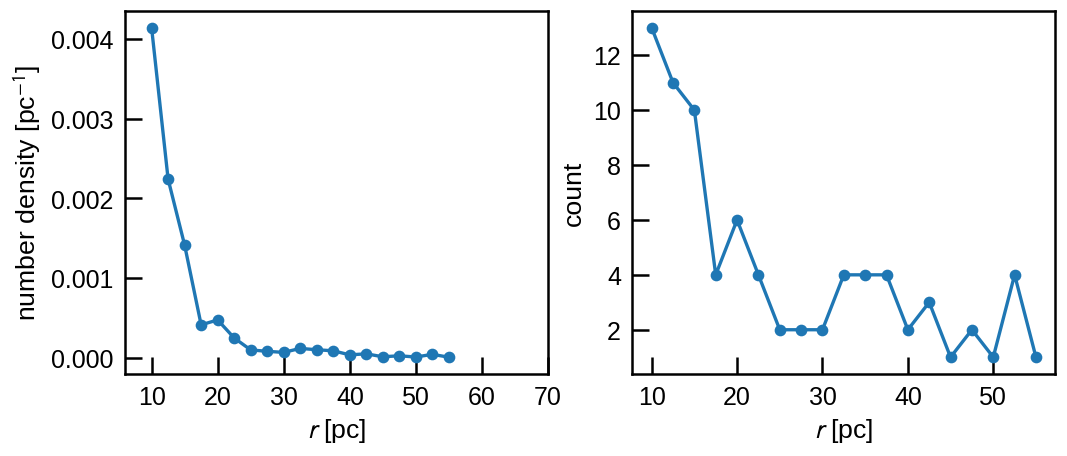

In [8]:
count, bin_edges = np.histogram(r_reino, bins=np.arange(10, 60, 2.5,) - 2.5/2.)
binsize = bin_edges[1]-bin_edges[0]
bin_center = (bin_edges[1:]+bin_edges[:-1])*0.5
numdens = count / (4*np.pi * bin_center**2  * binsize)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plt.sca(ax[0])
plt.plot(bin_center, numdens, marker='o');
plt.xlabel("$r$ [pc]")
plt.ylabel("number density [pc$^{-1}$]");
plt.xlim(6, 70)
plt.xticks([10,20,30,40,50,60, 70])
# plt.axhline(0.005, lw=1, c='gray')
# plt.axhline(0.040, lw=1, c='gray')

ax[1].plot(bin_center, count, marker='o');
ax[1].set_xlabel("$r$ [pc]")
ax[1].set_ylabel("count");

As another sanity check, according to their plot, at 10 pc, there should be roughly $4 \pi r^2 = (0.035-0.010)  4\pi 10^2 \approx 31\,\mathrm{pc}^{-1}$ stars and at 20 pc, $20\,\mathrm{pc}^{-1}$ stars yet as can be seen on the right plot, the cluster contains less stars so something is amiss.

In [7]:
0.025*4*np.pi*10**2, 0.004*4*np.pi*20**2

(31.41592653589793, 20.106192982974676)

As another check, let's (wrongly) assume that all stars beyond 10 pc is between 10 pc and 20 pc, and see what density we get:

In [16]:
def sphere_volume(r):
    return 4*np.pi/3*r**3

(r_reino>10).sum() / (sphere_volume(20)-sphere_volume(10))

0.002557847299691175

## Density profile from Reino 2018 and DR2 sample

In [7]:
def calculate_numdens(rr, bins=None):
    if bins is None:
        bins=np.arange(2./2., 30, 2.,) - 2./2.
    count, bin_edges = np.histogram(rr, bins=bins)
    binsize = bin_edges[1]-bin_edges[0]
    bin_center = (bin_edges[1:]+bin_edges[:-1])*0.5
    numdens = count / (4*np.pi * bin_center**2  * binsize)
    numdens_1sig = np.sqrt(count) / (4*np.pi * bin_center**2  * binsize)
    return bin_center, count, numdens, numdens_1sig

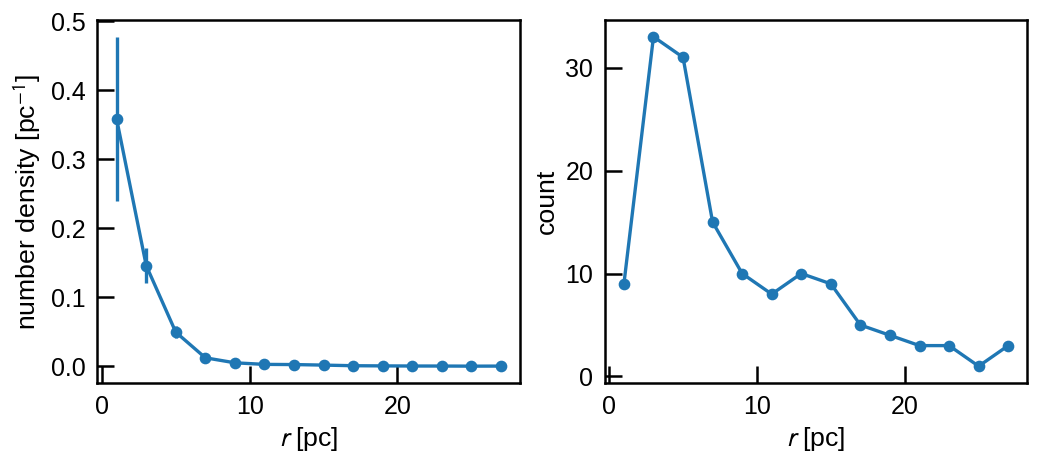

In [8]:
bin_center, count_reino, numdens_reino, numdens_1sig_reino = calculate_numdens(r_reino)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plt.sca(ax[0])
plt.errorbar(bin_center, numdens_reino, yerr=numdens_1sig_reino, marker='o');
plt.xlabel("$r$ [pc]")
plt.ylabel("number density [pc$^{-1}$]");
# ax[0].set_xscale('log')
# ax[0].set_yscale('log');


ax[1].plot(bin_center, count_reino, marker='o');
ax[1].set_xlabel("$r$ [pc]")
ax[1].set_ylabel("count");

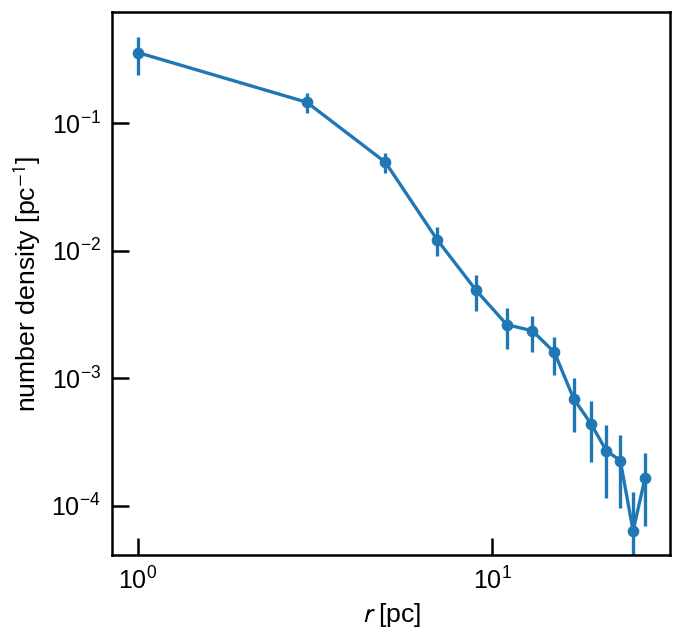

In [9]:
plt.errorbar(bin_center, numdens_reino, yerr=numdens_1sig_reino, marker='o');
plt.xscale('log');
plt.yscale('log');
plt.xlabel('$r$ [pc]')
plt.ylabel('number density [pc$^{-1}$]');

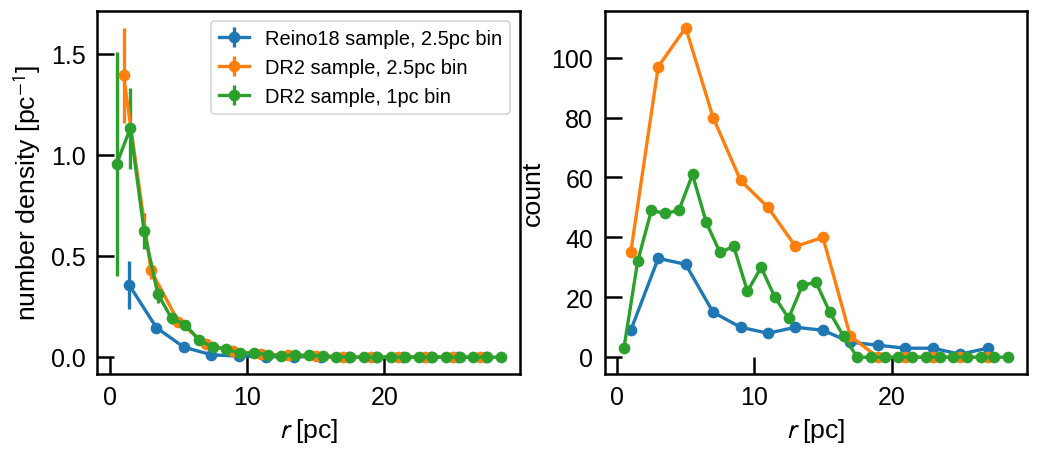

In [12]:
bin_center, count_dr2, numdens_dr2, numdens_1sig_dr2 = calculate_numdens(r)
bin_center1, count_dr21, numdens_dr21, numdens_1sig_dr21 = calculate_numdens(r, bins=np.arange(0.5,30,1)-0.5)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plt.sca(ax[0])
plt.errorbar(bin_center+0.4, numdens_reino, yerr=numdens_1sig_reino, marker='o', label='Reino18 sample, 2.5pc bin');
plt.errorbar(bin_center, numdens_dr2, yerr=numdens_1sig_dr2, marker='o', label='DR2 sample, 2.5pc bin');
plt.errorbar(bin_center1, numdens_dr21, yerr=numdens_1sig_dr21, marker='o', label='DR2 sample, 1pc bin');

plt.xlabel("$r$ [pc]")
plt.ylabel("number density [pc$^{-1}$]");
# ax[0].set_xscale('log')
# ax[0].set_yscale('log');

ax[1].plot(bin_center, count_reino, marker='o');
ax[1].plot(bin_center, count_dr2, marker='o');
ax[1].plot(bin_center1, count_dr21, marker='o');


ax[1].set_xlabel("$r$ [pc]")
ax[1].set_ylabel("count");
ax[0].legend(loc='upper right', fontsize=12);

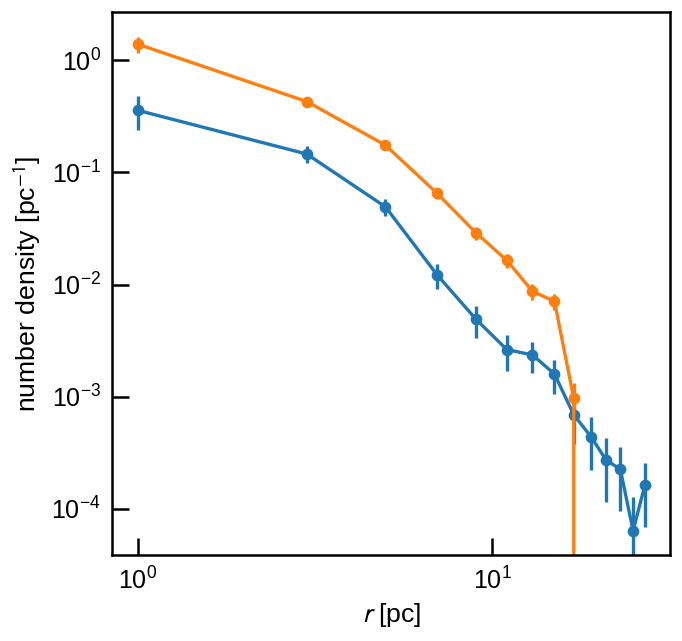

In [12]:
plt.errorbar(bin_center, numdens_reino, yerr=numdens_1sig_reino, marker='o');
plt.errorbar(bin_center, numdens_dr2, yerr=numdens_1sig_dr2, marker='o');
plt.xscale('log');
plt.yscale('log');
plt.xlabel('$r$ [pc]')
plt.ylabel('number density [pc$^{-1}$]');

In [13]:
m19 = out_full.groupby("in_meingast").get_group(True)
r19 = out_full.groupby("in_roser").get_group(True)

In [14]:
relpose_m19 = m19.g.galactic.cartesian.xyz.value - b_c[:,None]
relpose_r19 = r19.g.galactic.cartesian.xyz.value - b_c[:,None]

(-22, 22)

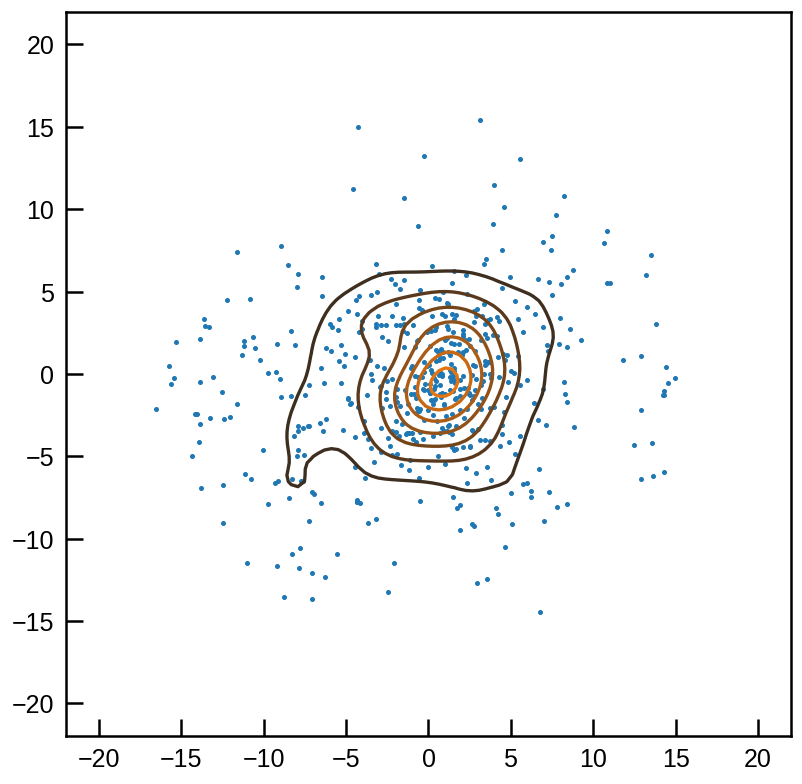

In [15]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_aspect('equal')
sns.kdeplot(relpos[0], relpos[1], color='C1');
plt.scatter(relpos[0], relpos[1], s=4)
# plt.scatter(relpose_m19[0], relpose_m19[1], s=4)
# plt.scatter(relpose_r19[0], relpose_r19[1], s=4)
plt.xlim(-22,22)
plt.ylim(-22,22)

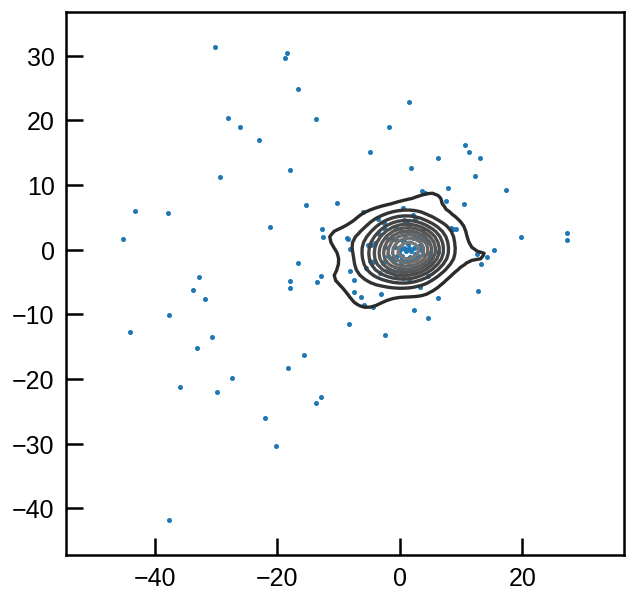

In [16]:
sns.kdeplot(relpos_reino[0], relpos_reino[1], ax=plt.gca(), color='C7');
plt.scatter(relpos_reino[0], relpos_reino[1], s=4)

(-12, 12)

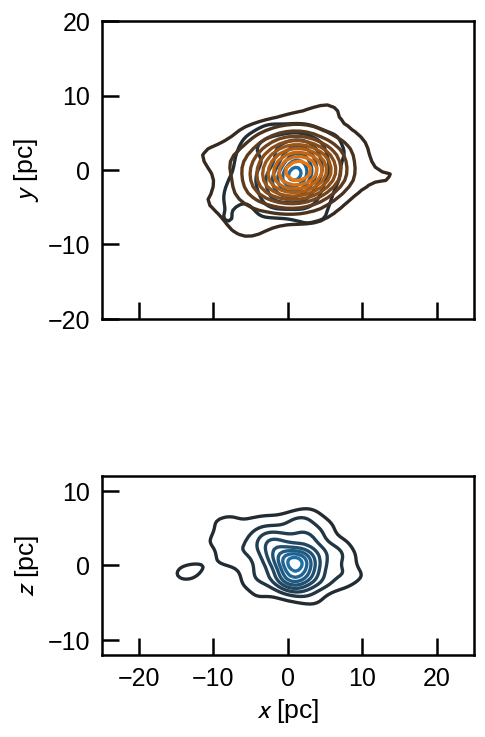

In [17]:
fig, ax = plt.subplots(2, 1, figsize=(4, 8), sharex=True)
sns.kdeplot(relpos[0], relpos[1], ax=ax[0]);
sns.kdeplot(relpos[0], relpos[2], ax=ax[1]);

sns.kdeplot(relpos_reino[0], relpos_reino[1], ax=ax[0]);
# sns.kdeplot(relpos_reino[0], relpos_reino[2], ax=ax[1]);

ax[1].set_xlabel('$x$ [pc]')
ax[1].set_ylabel('$z$ [pc]')
ax[0].set_ylabel('$y$ [pc]');
ax[0].set_xticks(np.arange(-20,21,10))
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
ax[0].set_xlim(-25,25);
ax[0].set_ylim(-20,20)
ax[1].set_ylim(-12,12)

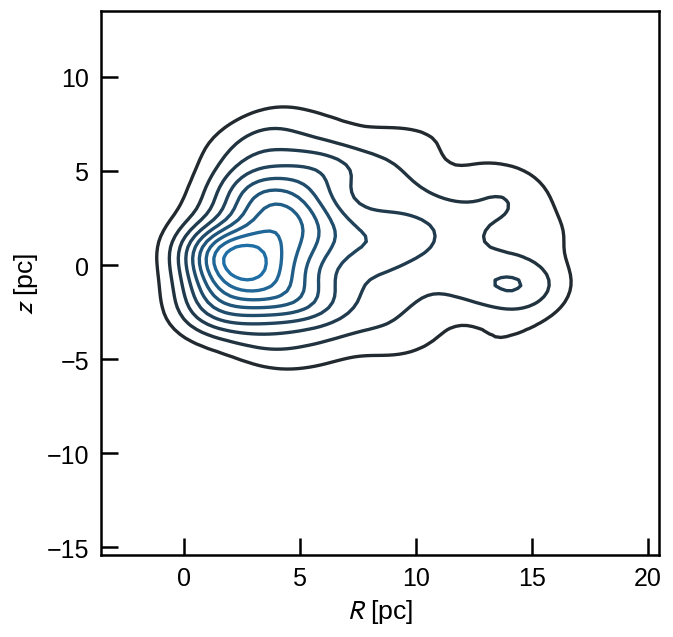

In [18]:
sns.kdeplot(np.hypot(relpos[0], relpos[1]), relpos[2]);
plt.xlabel("$R$ [pc]")
plt.ylabel("$z$ [pc]");

## Converting color to mass using an isochrone

(In progress)

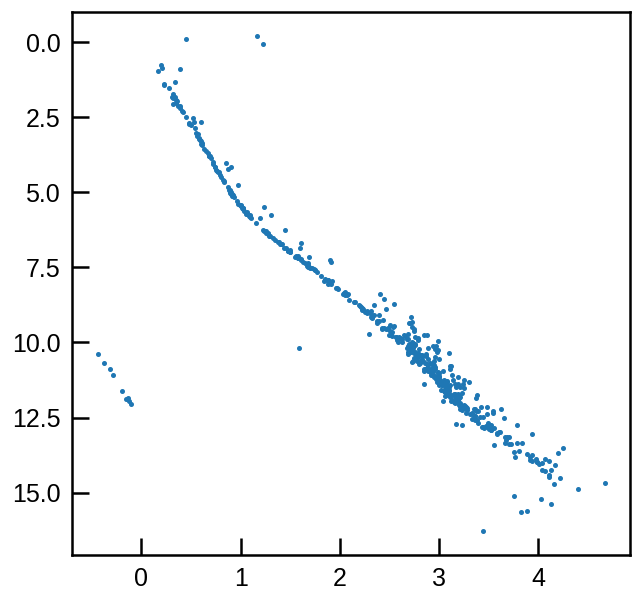

In [153]:
fig, ax = plt.subplots()
ax.scatter(df['bp_rp'], df['phot_g_mean_mag'] + df.g.distmod, s=4);
ax.invert_yaxis();k